# 时间序列的特征工程

reference:
> [多变量时间序列回归](https://blog.51cto.com/u_16213719/8774702)

In [1]:
import pandas as pd
import numpy as np

buoy = pd.read_csv('data/smart_buoy.csv', 
                    skiprows=[1], 
                    parse_dates=['time'])
 # setting time as index
buoy.set_index('time', inplace=True)
buoy.drop("station_id",axis=1,inplace=True)
 # simplifying column names
buoy.columns = [
     'PeakP', 'PeakD', 'Upcross',
     'SWH', 'SeaTemp', 'Hmax', 'THmax',
     'MCurDir', 'MCurSpd'
 ]
buoy.dropna(subset="SWH",axis=0,inplace=True)

In [2]:
# resampling to hourly data
buoy = buoy.resample('H').mean()


In [3]:
import pandas as pd
 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.multioutput import MultiOutputRegressor
from lightgbm import LGBMRegressor
 
 # https://github.com/vcerqueira/blog/blob/main/src/tde.py
from src.tde import time_delay_embedding
 
target_var = 'SWH'
colnames = buoy.columns
 
 # create data set with lagged features using time delay embedding
buoy_ds = []
for col in buoy:
     col_df = time_delay_embedding(buoy[col], n_lags=24, horizon=12)
     buoy_ds.append(col_df)
 
 # concatenating all variables
buoy_df = pd.concat(buoy_ds, axis=1).dropna()
 
 # defining target (Y) and explanatory variables (X)
predictor_variables = buoy_df.columns.str.contains('\(t\-')
target_variables = buoy_df.columns.str.contains(f'{target_var}\(t\+')
X = buoy_df.iloc[:, predictor_variables]
Y = buoy_df.iloc[:, target_variables]
 
 # train/test split
X_tr, X_ts, Y_tr, Y_ts = train_test_split(X, Y, test_size=0.3, shuffle=False)
 
 # fitting a lgbm model without feature engineering
model_wo_fe = MultiOutputRegressor(LGBMRegressor())
model_wo_fe.fit(X_tr, Y_tr)
 
preds_wo_fe = model_wo_fe.predict(X_ts)
mape(Y_ts, preds_wo_fe)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 52716
[LightGBM] [Info] Number of data points in the train set: 3246, number of used features: 207
[LightGBM] [Info] Start training from score 79.794824
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003811 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 52716
[LightGBM] [Info] Number of data points in the train set: 3246, number of used features: 207
[LightGBM] [Info] Start training from score 79.728897
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009007 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 52716
[LightGBM] [Info] Number of data points in the train set: 3246, number of used features: 207
[LightGBM] [Info] Star

0.2697454397205288

多元时间序列的特征工程
+ 单变量特征提取。计算各变量的滚动统计。例如，滚动平均可以用来消除虚假的观测;
+ 二元特征提取。计算变量对的滚动统计，以总结它们的相互作用。例如，两个变量之间的滚动协方差。

单变量
+ 总结每个变量最近的过去值。
+ 计算滚动平均来总结最近的情况。或者滚动差量来了解最近的分散程度。

In [15]:

 
SUMMARY_STATS = {
     'mean': np.mean,
     'sdev': np.std,
 }
 
univariate_features = {}
 # for each column in the data
for col in colnames:
     # get lags for that column
     X_col = X.iloc[:, X.columns.str.startswith(col)]
 
     # for each summary stat
     for feat, func in SUMMARY_STATS.items():
         # compute that stat along the rows
         univariate_features[f'{col}_{feat}'] = X_col.apply(func, axis=1)
 
 # concatenate features into a pd.DF
univariate_features_df = pd.concat(univariate_features, axis=1)

二元特征提取

+ 单变量统计漏掉了不同变量之间潜在的相互作用。所以我们可以使用二元特征提取过程捕获这些信息
+ 为不同的变量对计算特征。可以使用二元统计总结了这些对的联合动态
+ + 滚动二元统计。计算以变量对作为输入的统计信息。例如，滚动协方差或滚动相关性滚动二元统计的例子包括协方差、相关性或相对熵。 
+ + 滚动二元变换，然后单变量统计。这将一对变量转换为一个变量，并对该变量进行统计。例如，计算元素相互关系，然后取其平均值。有许多二元转换的方法。例如，百分比差异、相互关联或成对变量之间的线性卷积。通过第一步操作后，用平均值或标准偏差等统计数据对这些转换进行汇总。

In [13]:
import itertools
 
import pandas as pd
 
from scipy.spatial.distance import jensenshannon
from scipy import signal
from scipy.special import rel_entr
 
from src.feature_extraction import covariance, co_integration

SUMMARY_STATS = {
     'mean': np.mean,
     'sdev': np.std,#标准差
 }

BIVARIATE_STATS = {
     'covariance': covariance, #协方差
     'co_integration': co_integration,#相关性
     'js_div': jensenshannon,#JS 散度
 }
 
BIVARIATE_TRANSFORMATIONS = {
     'corr': signal.correlate,#相互关联
     'conv': signal.convolve,#卷积
     'rel_entr': rel_entr,#相对熵
 }
 
 # get all pairs of variables
col_combs = list(itertools.combinations(colnames, 2))
 
bivariate_features = []
 # for each row
for i, _ in X.iterrows():
     # feature set in the i-th time-step
     feature_set_i = {}
     for col1, col2 in col_combs:
         # features for pair of columns col1, col2
 
         # getting the i-th instance for each column
         x1 = X.loc[i, X.columns.str.startswith(str(col1))]
         x2 = X.loc[i, X.columns.str.startswith((str(col2)))]
 
         # compute each summary stat
         for feat, func in BIVARIATE_STATS.items():
             feature_set_i[f'{col1}|{col2}_{feat}'] = func(x1, x2)
 
         # for each transformation
         for trans_f, t_func in BIVARIATE_TRANSFORMATIONS.items():
 
             # apply transformation
             xt = t_func(x1, x2)
 
             # compute summary stat
             for feat, s_func in SUMMARY_STATS.items():
                 feature_set_i[f'{col1}|{col2}_{trans_f}_{feat}'] = s_func(xt)
 
     bivariate_features.append(feature_set_i)
 
bivariate_features_df = pd.DataFrame(bivariate_features, index=X.index)

In [16]:
# concatenating all features with lags
X_with_features = pd.concat([X, univariate_features_df, bivariate_features_df], axis=1)

# train/test split
X_tr, X_ts, Y_tr, Y_ts = train_test_split(X_with_features, Y, test_size=0.3, shuffle=False)

# fitting a lgbm model with feature engineering
model_w_fe = MultiOutputRegressor(LGBMRegressor())
model_w_fe.fit(X_tr, Y_tr)

# getting forecasts for the test set
preds_w_fe = model_w_fe.predict(X_ts)

# computing MAPE error
print(mape(Y_ts, preds_w_fe))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007748 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 121566
[LightGBM] [Info] Number of data points in the train set: 3246, number of used features: 477
[LightGBM] [Info] Start training from score 79.794824
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007861 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 121566
[LightGBM] [Info] Number of data points in the train set: 3246, number of used features: 477
[LightGBM] [Info] Start training from score 79.728897
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007794 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 121566
[LightGBM] [Info] Number of data points in the train set: 3246, number of used features: 477
[LightGBM] [Info] S

In [17]:
# getting the importance of each feature in each horizon
avg_imp = pd.DataFrame([x.feature_importances_
                        for x in model_w_fe.estimators_]).mean()

# getting the top 100 features
n_top_features = 100

importance_scores = pd.Series(dict(zip(X_tr.columns, avg_imp)))
top_features = importance_scores.sort_values(ascending=False)[:n_top_features]
top_features_nm = top_features.index

# subsetting training and testing sets by those features
X_tr_top = X_tr[top_features_nm]
X_ts_top = X_ts[top_features_nm]

# re-fitting the lgbm model
model_top_features = MultiOutputRegressor(LGBMRegressor())
model_top_features.fit(X_tr_top, Y_tr)

# getting forecasts for the test set
preds_top_feats = model_top_features.predict(X_ts_top)

# computing MAE error
mape(Y_ts, preds_top_feats)
# 0.229

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000841 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25497
[LightGBM] [Info] Number of data points in the train set: 3246, number of used features: 100
[LightGBM] [Info] Start training from score 79.794824
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25497
[LightGBM] [Info] Number of data points in the train set: 3246, number of used features: 100
[LightGBM] [Info] Start training from score 79.728897
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000963 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25497
[LightGBM] [Info] Number of data points in the train set: 3246, number of used features: 100
[LightGBM] [Info] Star

0.24712957233773894

<Axes: xlabel='time'>

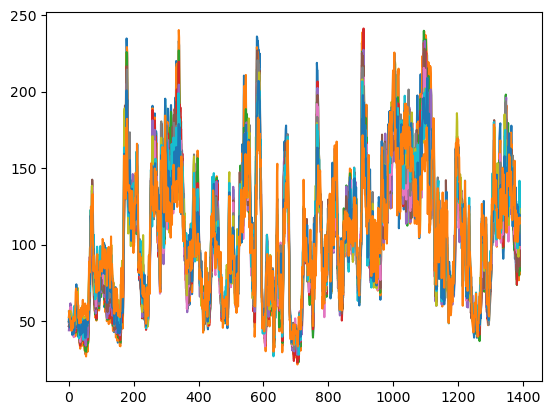

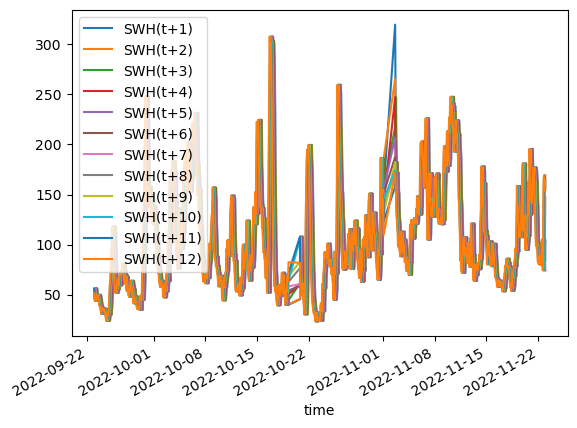

In [23]:
import matplotlib.pyplot as plt 
plt.plot(preds_wo_fe)
Y_ts.plot()

用几句话总结本文的关键点：
+ 多变量时间序列预测通常是一个自回归过程
+ 特征工程是数据科学项目中的一个关键步骤。
+ 可以用特征工程改进多元时间序列数据。这包括计算单变量和双变量转换和汇总统计信息。提取过多的特征会导致高维问题。
+ 可以使用特征选择方法来删除不需要的特征。